# 06 — Zone Comparison & Key Findings

**Phase 2a: Feature Engineering — Cross-Zone Analysis**

## What you'll learn

- How the 5 Norwegian bidding zones **differ from each other**
- Which features **vary most between zones** (modeling implications)
- Whether to train **one model per zone** or one model with zone as a feature
- Key findings that will guide Phase 3 modeling decisions

## Why zones matter

Norway has 5 electricity bidding zones because grid capacity between regions is **limited**. When transmission lines are congested, zones get different prices.

```
              NO_4 (Tromsø)
                ↓
              NO_3 (Trondheim)
              ↙    ↘
  NO_5 (Bergen)    NO_1 (Oslo)
         ↘        ↙
         NO_2 (Kristiansand)
           ↓ ↓ ↓ ↓
         Cables to EU
```

**NO_2** has the most international cables → most exposed to European prices.
**NO_4** is geographically isolated → often has different prices.

In [1]:
import sys
from pathlib import Path

PROJECT_ROOT = str(Path.cwd().parent) if Path("../src").exists() else str(Path.cwd())
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from src.features.build_features import ZONE_LABELS, ALL_ZONES

ZONE_COLORS = {
    "NO_1": "tab:blue", "NO_2": "tab:orange",
    "NO_3": "tab:green", "NO_4": "tab:purple", "NO_5": "tab:red",
}
START, END = "2020-01-01", "2026-02-21"

## Load cached feature matrices

Run notebook 05 first if these files don't exist.

In [2]:
processed_dir = Path("../data/processed")

all_dfs = {}
for zone in ALL_ZONES:
    path = processed_dir / f"features_{zone}_{START}_{END}.parquet"
    if path.exists():
        all_dfs[zone] = pd.read_parquet(path)
        print(f"{zone}: loaded ({all_dfs[zone].shape[0]:,} x {all_dfs[zone].shape[1]})")
    else:
        print(f"{zone}: NOT FOUND — run notebook 05 first")

print(f"\nLoaded {len(all_dfs)}/{len(ALL_ZONES)} zones")

NO_1: loaded (53,833 x 68)
NO_2: loaded (53,833 x 75)
NO_3: loaded (53,833 x 68)
NO_4: loaded (53,833 x 74)
NO_5: loaded (53,833 x 63)

Loaded 5/5 zones


## Finding 1: Temperature Regimes are Vastly Different

This is the **most important zone-specific feature**. Norway spans from 58°N (Kristiansand) to 69°N (Tromsø — above the Arctic Circle).

### Why temperature matters for electricity pricing

Norway heats primarily with electricity (unlike most of Europe which uses gas). This creates a direct link:

$$\text{Heating demand} \propto \max(0,\; T_{\text{base}} - T_{\text{actual}})$$

where $T_{\text{base}} \approx 17\text{°C}$ is a comfort threshold. This quantity is called **Heating Degree Days (HDD)**.

- When $T < T_{\text{base}}$: every 1°C drop increases heating demand roughly linearly
- When $T > T_{\text{base}}$: heating demand is ~0 (Norway has minimal cooling demand)

### What the plots below show

| Plot | What it tells us |
|------|------------------|
| **Box plot** (left) | Distribution of temperatures per zone — median, IQR, range. NO_4 (Tromsø) has the lowest median and widest cold tail. |
| **Monthly bar chart** (right) | Seasonal cycle per zone. All zones are cold in winter, but the **gap between zones** is largest in winter (5–15°C). |

### Modeling implication

A model trained on NO_4 (Tromsø) data will learn that cold = normal, while a model trained on NO_2 (Kristiansand) will learn that cold = unusual spike in demand. This is why **zone-specific models** may outperform a single national model — the temperature→demand relationship has different parameters per zone.

**Key concept — Pearson correlation ($r$):**

$$r = \frac{\sum(x_i - \bar{x})(y_i - \bar{y})}{\sqrt{\sum(x_i - \bar{x})^2 \cdot \sum(y_i - \bar{y})^2}}$$

Ranges from $-1$ (perfect negative) to $+1$ (perfect positive). We expect $r < 0$ for temperature vs price (colder → more expensive).

/var/folders/_2/_llw2n8s67n_9kq4z4d57vvr0000gn/T/ipykernel_7156/3313825233.py:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(temp_data, labels=labels, patch_artist=True)


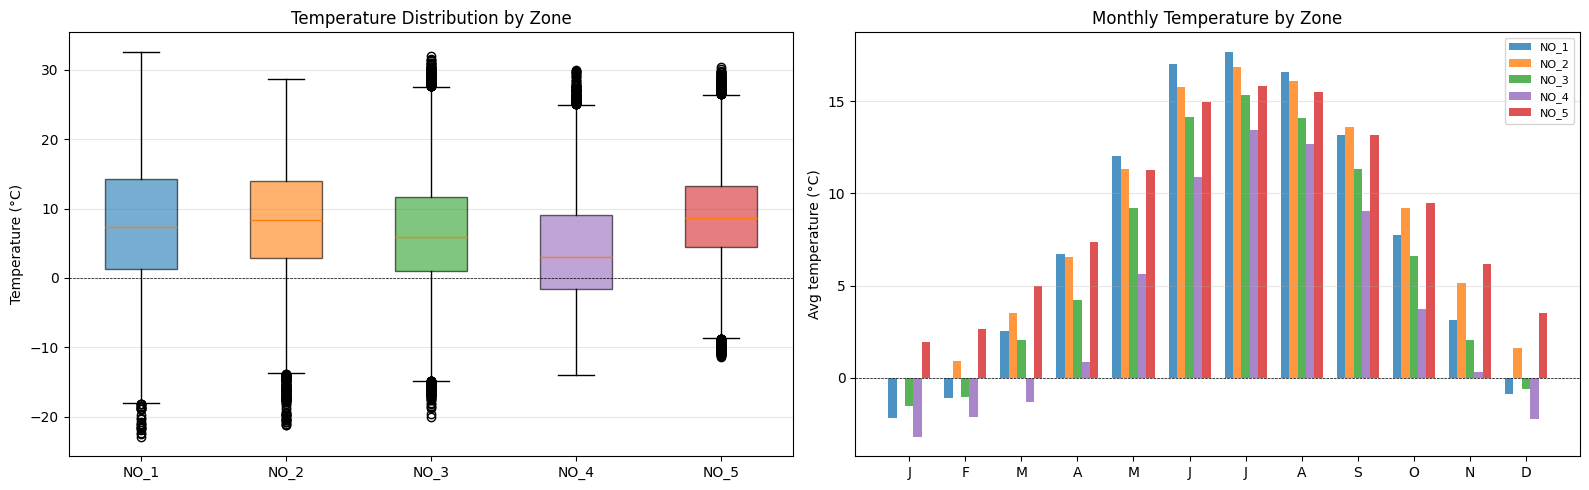

FINDING: Temperature spread between zones is 5-15°C in winter.
This means heating demand (and thus price) patterns differ significantly.
→ Implication: zone-specific models may outperform a single national model.


In [3]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Box plot: temperature distribution per zone
ax = axes[0]
temp_data = []
labels = []
for zone in all_dfs:
    if "temperature" in all_dfs[zone].columns:
        temp_data.append(all_dfs[zone]["temperature"].dropna().values)
        labels.append(zone)

if temp_data:
    bp = ax.boxplot(temp_data, labels=labels, patch_artist=True)
    for i, patch in enumerate(bp["boxes"]):
        patch.set_facecolor(ZONE_COLORS[labels[i]])
        patch.set_alpha(0.6)
    ax.axhline(y=0, color="black", linewidth=0.5, linestyle="--")
    ax.set_ylabel("Temperature (°C)")
    ax.set_title("Temperature Distribution by Zone")
    ax.grid(True, alpha=0.3, axis="y")

# Bar chart: average by month per zone
ax = axes[1]
x = np.arange(12)
width = 0.15
month_labels = ["J","F","M","A","M","J","J","A","S","O","N","D"]

for i, zone in enumerate(all_dfs):
    if "temperature" in all_dfs[zone].columns:
        monthly = all_dfs[zone].groupby("month")["temperature"].mean()
        ax.bar(x + i * width, monthly.values, width,
               color=ZONE_COLORS[zone], alpha=0.8, label=zone)

ax.set_xticks(x + width * 2)
ax.set_xticklabels(month_labels)
ax.axhline(y=0, color="black", linewidth=0.5, linestyle="--")
ax.set_ylabel("Avg temperature (°C)")
ax.set_title("Monthly Temperature by Zone")
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3, axis="y")

plt.tight_layout()
plt.show()

print("FINDING: Temperature spread between zones is 5-15°C in winter.")
print("This means heating demand (and thus price) patterns differ significantly.")
print("→ Implication: zone-specific models may outperform a single national model.")

## Finding 2: Reservoir Levels Drive South vs North Price Splits

NO_2 + NO_5 hold ~55% of Norway's total hydro capacity. When their reservoirs are low, southern prices decouple from the north.

### The economics of hydro reservoirs

Norway generates ~95% of its electricity from **hydropower**. The reservoirs act as a giant battery:

- **Spring/summer**: Snow melts + rain → reservoirs fill (cheap electricity)
- **Autumn/winter**: Heating demand peaks + less inflow → reservoirs drain (expensive electricity)

The key concept is **water value** — the opportunity cost of using water now vs saving it:

$$V_{\text{water}} = E[\text{future price}] \times \text{generation efficiency (MWh/m³)}$$

When reservoirs are low, water value increases because scarcity drives up expected future prices. Hydro producers bid higher into the day-ahead market → prices rise.

### The 20-year median benchmark

NVE (Norwegian Water Resources Directorate) publishes min/max/median filling levels based on the last 20 years of data. The **deviation from median** is a key scarcity signal:

$$\Delta_{\text{median}} = \text{filling}_{\text{actual}} - \text{filling}_{\text{median}}$$

- $\Delta_{\text{median}} < 0$: reservoirs below normal → scarcity risk → higher prices
- $\Delta_{\text{median}} > 0$: reservoirs above normal → surplus → lower prices

### What the plots below show

| Plot | What it tells us |
|------|------------------|
| **Filling trajectories** (top) | All 5 zones overlaid. The annual cycle is visible (fill in summer, drain in winter). The 2022 drawdown is clearly visible. |
| **Capacity bar chart** (bottom) | Estimated TWh capacity per zone. NO_2 + NO_5 dominate — this is why southern prices are most sensitive to reservoir levels. |

### Why this creates a North–South price split

NO_3 and NO_4 (north) have their own reservoirs and limited cable connections south. When southern reservoirs are low, northern ones may still be healthy. But transmission capacity between north and south is limited, so the cheap northern power can't flow south fast enough → price divergence.

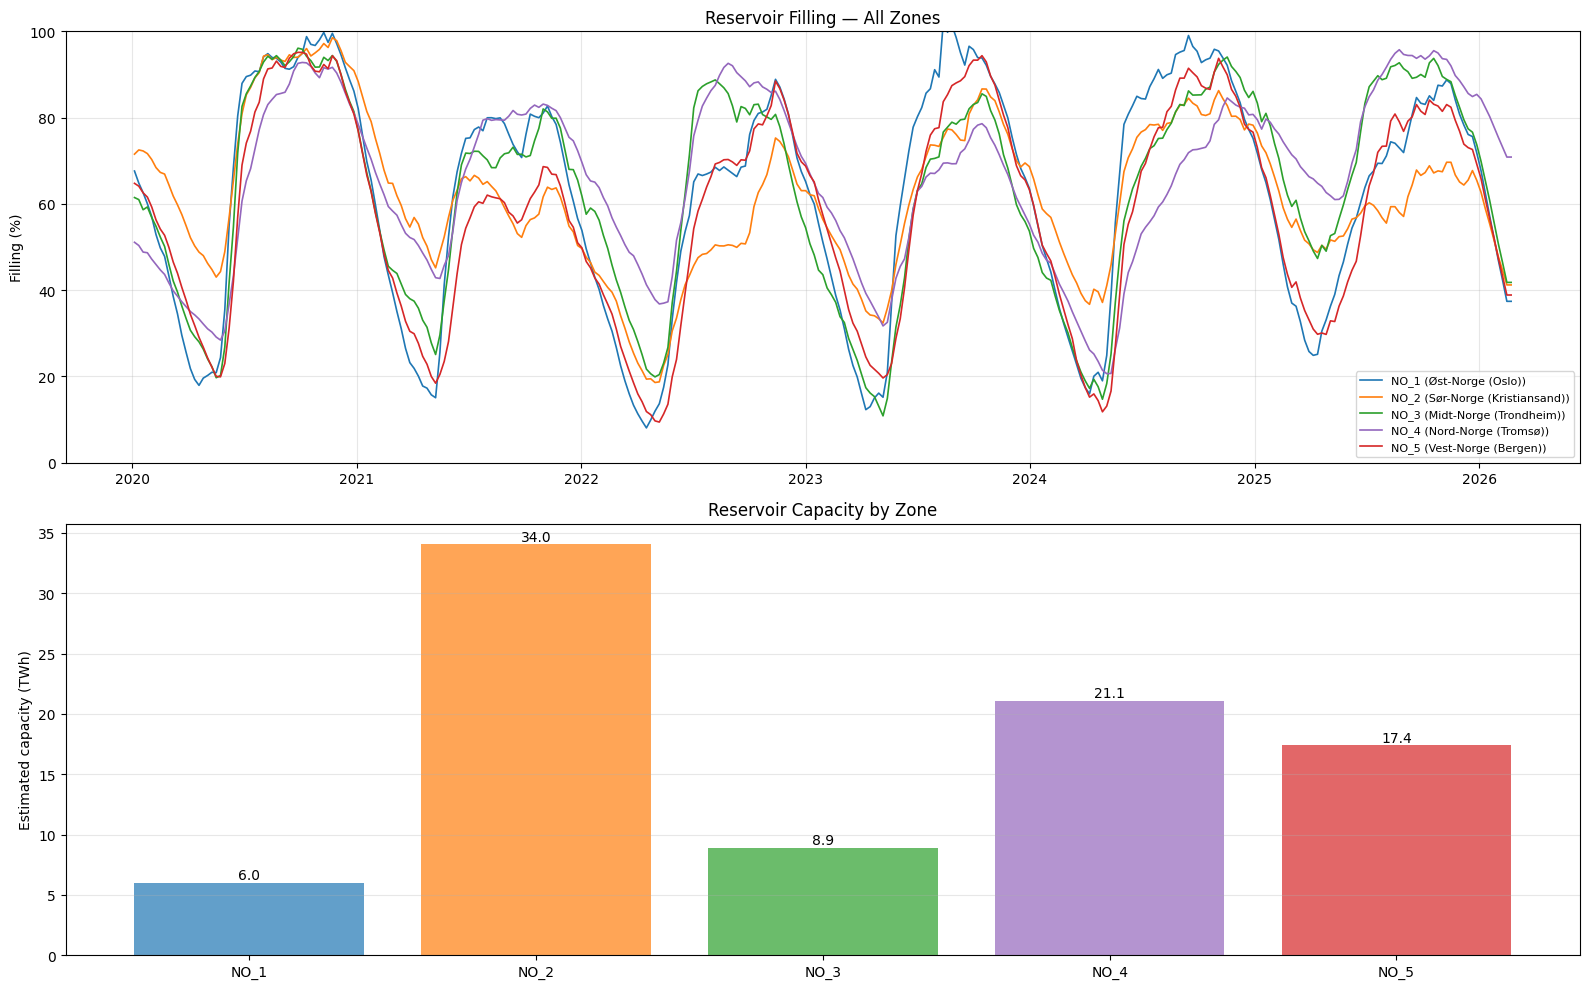

Total estimated capacity: 87.4 TWh
NO_2 + NO_5 (south/west): 51.4 TWh (59% of total)

FINDING: Southern zones hold most capacity.
When their reservoirs drop, prices spike in NO_1/NO_2/NO_5.
NO_3/NO_4 can stay cheap if their own reservoirs are healthy.


In [4]:
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# Panel 1: Filling levels
ax = axes[0]
for zone in all_dfs:
    if "reservoir_filling_pct" in all_dfs[zone].columns:
        weekly = all_dfs[zone]["reservoir_filling_pct"].resample("W").last().dropna()
        ax.plot(weekly.index, weekly.values * 100, color=ZONE_COLORS[zone],
                linewidth=1.2, label=f"{zone} ({ZONE_LABELS[zone]})")

ax.set_ylabel("Filling (%)")
ax.set_title("Reservoir Filling — All Zones")
ax.set_ylim(0, 100)
ax.legend(loc="lower right", fontsize=8)
ax.grid(True, alpha=0.3)

# Panel 2: Capacity comparison
ax = axes[1]
capacities = {}
for zone in all_dfs:
    if "reservoir_filling_twh" in all_dfs[zone].columns:
        # Capacity ≈ max TWh observed / max filling_pct
        max_twh = all_dfs[zone]["reservoir_filling_twh"].max()
        max_pct = all_dfs[zone]["reservoir_filling_pct"].max()
        if max_pct > 0:
            capacities[zone] = max_twh / max_pct

if capacities:
    zones = list(capacities.keys())
    caps = [capacities[z] for z in zones]
    colors = [ZONE_COLORS[z] for z in zones]
    bars = ax.bar(zones, caps, color=colors, alpha=0.7)
    for bar, cap in zip(bars, caps):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.3,
                f"{cap:.1f}", ha="center", fontsize=10)
    ax.set_ylabel("Estimated capacity (TWh)")
    ax.set_title("Reservoir Capacity by Zone")
    ax.grid(True, alpha=0.3, axis="y")

plt.tight_layout()
plt.show()

if capacities:
    total = sum(caps)
    south = capacities.get("NO_2", 0) + capacities.get("NO_5", 0)
    print(f"Total estimated capacity: {total:.1f} TWh")
    print(f"NO_2 + NO_5 (south/west): {south:.1f} TWh ({south/total:.0%} of total)")
    print("\nFINDING: Southern zones hold most capacity.")
    print("When their reservoirs drop, prices spike in NO_1/NO_2/NO_5.")
    print("NO_3/NO_4 can stay cheap if their own reservoirs are healthy.")

## Finding 3: Wind Speed and Precipitation Vary by Geography

Coastal zones (Bergen, Kristiansand) are windier than inland/northern zones.

### Wind power economics

Wind turbines generate power proportional to the cube of wind speed:

$$P_{\text{wind}} \propto v^3$$

This means doubling wind speed gives **8× the power output**. Wind generation is:
- Zero marginal cost (no fuel) → pushes prices down when it's windy
- Called the **merit order effect**: wind displaces expensive thermal generation, lowering the market clearing price

However, Norway is ~95% hydro, so the wind merit order effect is smaller than in Denmark or Germany where wind displaces gas/coal.

### Precipitation and reservoir recharge

Precipitation is a **leading indicator** for reservoir levels:

$$\Delta\text{reservoir}_{t+\tau} \approx f(\text{precipitation}_t, \text{snowmelt}_t) - \text{generation}_t$$

where $\tau$ is the lag between rainfall and reservoir filling (days to weeks depending on catchment size). Heavy rain today → fuller reservoirs next week → lower future prices.

### What the plots below show

| Plot | What it tells us |
|------|------------------|
| **Wind speed** (left) | Average wind speed per zone. Coastal zones (NO_2, NO_5) are windier due to Atlantic exposure. |
| **Precipitation** (right) | Daily rainfall per zone. Bergen (NO_5) is famous for rain — this keeps its reservoirs healthier than other zones. |

### Modeling implication

Wind speed may have a weak direct effect on prices in Norway, but precipitation is an important **leading feature** for reservoir levels. Including lagged precipitation (7–30 day rolling sums) could help predict future reservoir-driven price movements.

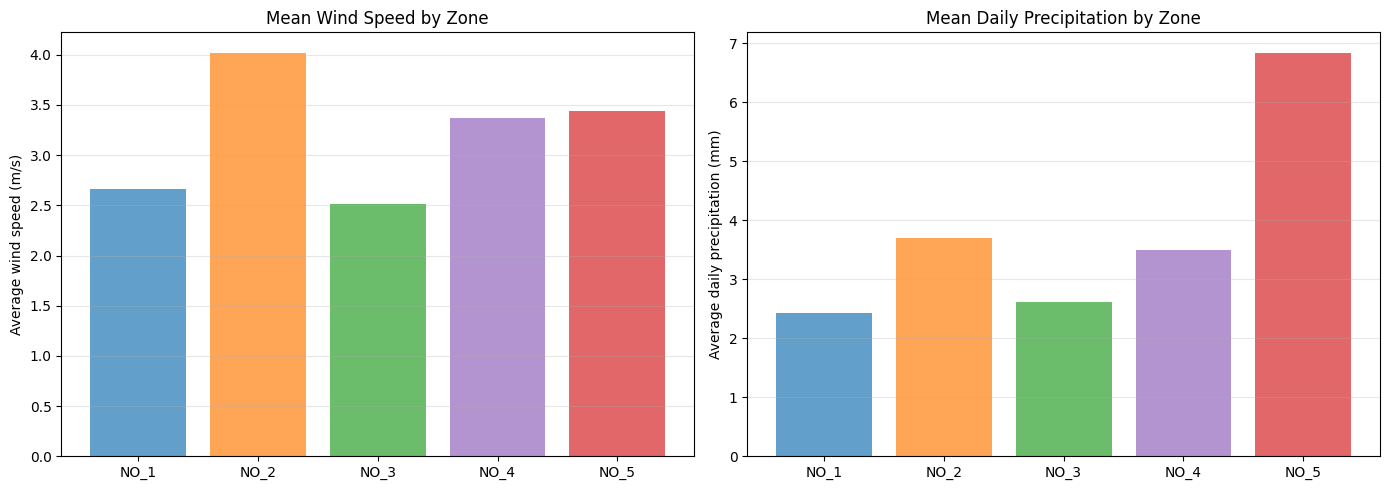

FINDING: Bergen (NO_5) gets the most precipitation — famous for rain.
This keeps NO_5 reservoirs healthier than other zones.


In [5]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Average wind speed
ax = axes[0]
wind_means = {}
for zone in all_dfs:
    if "wind_speed" in all_dfs[zone].columns:
        wind_means[zone] = all_dfs[zone]["wind_speed"].mean()

if wind_means:
    zones = list(wind_means.keys())
    means = [wind_means[z] for z in zones]
    colors = [ZONE_COLORS[z] for z in zones]
    ax.bar(zones, means, color=colors, alpha=0.7)
    ax.set_ylabel("Average wind speed (m/s)")
    ax.set_title("Mean Wind Speed by Zone")
    ax.grid(True, alpha=0.3, axis="y")

# Precipitation
ax = axes[1]
precip_means = {}
for zone in all_dfs:
    if "precipitation" in all_dfs[zone].columns:
        # Sum to daily then average
        daily = all_dfs[zone]["precipitation"].resample("D").sum()
        precip_means[zone] = daily.mean()

if precip_means:
    zones = list(precip_means.keys())
    means = [precip_means[z] for z in zones]
    colors = [ZONE_COLORS[z] for z in zones]
    ax.bar(zones, means, color=colors, alpha=0.7)
    ax.set_ylabel("Average daily precipitation (mm)")
    ax.set_title("Mean Daily Precipitation by Zone")
    ax.grid(True, alpha=0.3, axis="y")

plt.tight_layout()
plt.show()

print("FINDING: Bergen (NO_5) gets the most precipitation — famous for rain.")
print("This keeps NO_5 reservoirs healthier than other zones.")

## Finding 4: Feature Correlation Structure is Similar Across Zones

Let's check whether the same features are correlated the same way in each zone. If so, one model architecture might work for all zones.

### Understanding Pearson correlation

The table below shows **Pearson correlation coefficients** ($r$) between feature pairs, computed per zone:

$$r_{xy} = \frac{\text{Cov}(X, Y)}{\sigma_X \cdot \sigma_Y} = \frac{\sum(x_i - \bar{x})(y_i - \bar{y})}{\sqrt{\sum(x_i - \bar{x})^2} \cdot \sqrt{\sum(y_i - \bar{y})^2}}$$

| $|r|$ range | Interpretation |
|-------------|----------------|
| 0.0 – 0.2 | Negligible |
| 0.2 – 0.4 | Weak |
| 0.4 – 0.6 | Moderate |
| 0.6 – 0.8 | Strong |
| 0.8 – 1.0 | Very strong |

### What to look for

1. **National features** (commodities, Statnett production) should have **identical** correlations across zones — they're the same data for every zone. If they don't, something is wrong with the data join.

2. **Zone-specific features** (temperature, reservoir) should **differ** across zones — this is what makes each zone unique and justifies separate models.

3. **High correlation between features** ($|r| > 0.95$) signals **multicollinearity** — including both features in a linear model causes unstable coefficients. Tree models (XGBoost, CatBoost) are more robust to this, but it still wastes a feature slot.

### What the table below shows

Each row is a feature pair. Each column is a zone. Identical values across zones = national feature. Different values = zone-specific feature.

In [6]:
# Compare correlation of key feature pairs across zones
feature_pairs = [
    ("temperature", "month"),
    ("temperature", "reservoir_filling_pct"),
    ("wind_speed", "precipitation"),
    ("ttf_gas_close", "coal_close"),
    ("production_mwh", "consumption_mwh"),
    ("reservoir_filling_pct", "reservoir_vs_median"),
]

print(f"{'Feature pair':<45s}", end="")
for zone in all_dfs:
    print(f"{zone:>8s}", end="")
print()
print("-" * (45 + 8 * len(all_dfs)))

for f1, f2 in feature_pairs:
    print(f"{f1} × {f2:<25s}", end="")
    for zone, df in all_dfs.items():
        if f1 in df.columns and f2 in df.columns:
            r = df[f1].corr(df[f2])
            print(f"{r:>8.3f}", end="")
        else:
            print(f"{'N/A':>8s}", end="")
    print()

print("\nFINDING: National features (commodities, Statnett) have identical correlations.")
print("Zone-specific features (temp, reservoir) show meaningful differences.")

Feature pair                                     NO_1    NO_2    NO_3    NO_4    NO_5
-------------------------------------------------------------------------------------
temperature × month                       0.218   0.259   0.210   0.245   0.256
temperature × reservoir_filling_pct       0.191   0.039   0.193   0.108   0.082
wind_speed × precipitation               0.062   0.139   0.113   0.143   0.167
ttf_gas_close × coal_close                  0.901   0.901   0.901   0.901   0.901
production_mwh × consumption_mwh             0.789   0.789   0.789   0.789   0.789
reservoir_filling_pct × reservoir_vs_median         0.207   0.556   0.426   0.615   0.330

FINDING: National features (commodities, Statnett) have identical correlations.
Zone-specific features (temp, reservoir) show meaningful differences.


## Finding 5: Seasonal Patterns by Zone

Hour-of-day temperature patterns differ — this directly affects when electricity demand peaks.

### Reading the heatmap

The plots below show **average temperature** for each combination of **day-of-week** (y-axis) and **hour-of-day** (x-axis). Color encodes temperature:

- 🔵 **Blue/cool colors**: Below ~5°C → high heating demand period
- 🔴 **Red/warm colors**: Above ~10°C → low heating demand period

### What patterns to look for

1. **Daily cycle** (horizontal variation): Temperatures should be warmer in the afternoon (12–18h) and cooler at night (0–6h). This creates the daily price cycle.

2. **Weekend vs weekday** (vertical variation): If there's no difference, temperature is purely a physical phenomenon. But weekday vs weekend **demand** differs because offices/industry are closed on weekends.

3. **Zone differences**: NO_4 (Tromsø) should be uniformly colder — the heatmap will be mostly blue. Southern zones should show more contrast (warm afternoons, cold nights).

### Why this matters for feature engineering

The heatmap helps decide which **interaction features** to create:

- If the daily temperature cycle is strong → `hour_of_day × temperature` interaction may help
- If weekday/weekend patterns differ → `is_weekend × temperature` interaction may help
- If the zone differences are large → confirms that `zone` should be a feature (or use separate models)

### Calendar features recap

The calendar features we'll use in modeling:

| Feature | Type | Why it matters |
|---------|------|----------------|
| `hour_of_day` | Cyclical (0–23) | Daily demand cycle — peak at 8–9 AM and 17–18 PM |
| `day_of_week` | Cyclical (0–6) | Weekend effect — prices drop 20–40% |
| `month` | Cyclical (1–12) | Seasonal heating/cooling demand |
| `is_weekend` | Binary | Quick weekend flag |
| `is_holiday` | Binary | Norwegian public holidays act like weekends |

/var/folders/_2/_llw2n8s67n_9kq4z4d57vvr0000gn/T/ipykernel_7156/1320354101.py:25: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.92, 0.95])


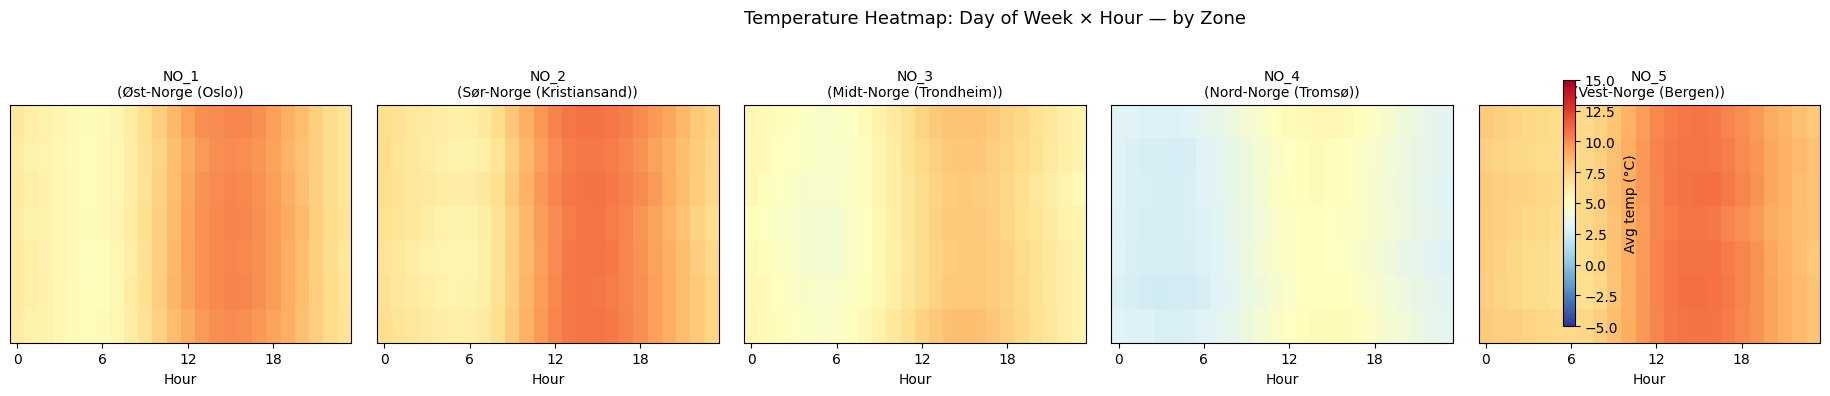

FINDING: NO_4 (Tromsø) is blue/cold everywhere — winter heating demand is constant.
Southern zones show warmer daytime temperatures — more pronounced daily cycle.


In [7]:
n_zones = len(all_dfs)
fig, axes = plt.subplots(1, n_zones, figsize=(4 * n_zones, 4), sharey=True)
if n_zones == 1:
    axes = [axes]

for i, (zone, df) in enumerate(all_dfs.items()):
    ax = axes[i]
    if "temperature" in df.columns:
        pivot = df.pivot_table(
            values="temperature", index="day_of_week", columns="hour_of_day", aggfunc="mean"
        )
        im = ax.imshow(pivot.values, aspect="auto", cmap="RdYlBu_r",
                       vmin=-5, vmax=15)
        ax.set_title(f"{zone}\n({ZONE_LABELS[zone]})", fontsize=10)
        ax.set_xticks(range(0, 24, 6))
        if i == 0:
            ax.set_yticks(range(7))
            ax.set_yticklabels(["Mon","Tue","Wed","Thu","Fri","Sat","Sun"], fontsize=8)
        else:
            ax.set_yticks([])
        ax.set_xlabel("Hour")

plt.colorbar(im, ax=axes, label="Avg temp (°C)", shrink=0.8)
fig.suptitle("Temperature Heatmap: Day of Week × Hour — by Zone", fontsize=13)
plt.tight_layout(rect=[0, 0, 0.92, 0.95])
plt.show()

print("FINDING: NO_4 (Tromsø) is blue/cold everywhere — winter heating demand is constant.")
print("Southern zones show warmer daytime temperatures — more pronounced daily cycle.")

## Finding 6: Per-Zone Consumption (ENTSO-E Load Data)

ENTSO-E provides **actual electricity consumption per zone** — a direct measurement of demand that we previously could only proxy through temperature.

### Why load data matters for modeling

Load (consumption in MW) is the most direct measure of demand. Combined with generation data, it tells us the actual supply-demand balance per zone — not a proxy, but the real thing.

/var/folders/_2/_llw2n8s67n_9kq4z4d57vvr0000gn/T/ipykernel_7156/1072002793.py:30: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(daily_data, labels=labels, patch_artist=True)


NO_1: 8760 hours, avg 3990 MW
NO_2: 744 hours, avg 5291 MW
NO_3: 8760 hours, avg 3233 MW
NO_4: 8760 hours, avg 2295 MW
NO_5: 744 hours, avg 2412 MW


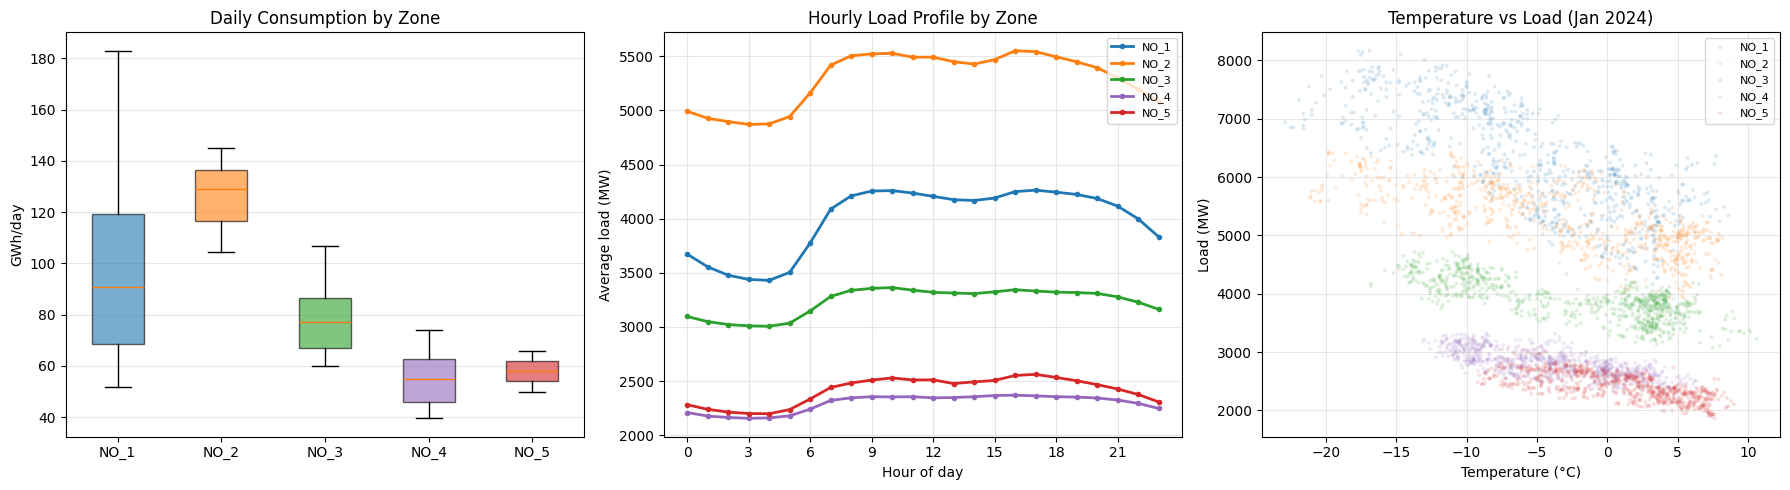


FINDING: NO_1 (Oslo) has the highest consumption — capital and largest population.
All zones show the same daily cycle: morning peak + evening peak.
Negative temperature-load correlation: colder → more electricity consumption.


In [8]:
# Check ENTSO-E availability
from src.features.build_features import ENTSOE_AVAILABLE

if ENTSOE_AVAILABLE:
    from src.data.fetch_electricity import fetch_load
    
    # Fetch load for all zones (1 month sample for speed)
    load_data = {}
    for zone in ALL_ZONES:
        try:
            raw = fetch_load(zone, "2024-01-01", "2024-02-01", cache=True)
            if not raw.empty:
                load_data[zone] = raw.iloc[:, 0]
                print(f"{zone}: {len(load_data[zone])} hours, avg {load_data[zone].mean():.0f} MW")
        except Exception as e:
            print(f"{zone}: {e}")
    
    if load_data:
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))
        
        # Box plot: daily consumption per zone
        ax = axes[0]
        daily_data = []
        labels = []
        for zone in ALL_ZONES:
            if zone in load_data:
                daily = load_data[zone].resample("D").sum() / 1000  # GWh/day
                daily_data.append(daily.dropna().values)
                labels.append(zone)
        bp = ax.boxplot(daily_data, labels=labels, patch_artist=True)
        for i, patch in enumerate(bp["boxes"]):
            patch.set_facecolor(ZONE_COLORS[labels[i]])
            patch.set_alpha(0.6)
        ax.set_ylabel("GWh/day")
        ax.set_title("Daily Consumption by Zone")
        ax.grid(True, alpha=0.3, axis="y")
        
        # Hourly load profile by zone
        ax = axes[1]
        for zone in ALL_ZONES:
            if zone in load_data:
                hourly_avg = load_data[zone].groupby(load_data[zone].index.hour).mean()
                ax.plot(hourly_avg.index, hourly_avg.values, color=ZONE_COLORS[zone],
                        linewidth=2, marker="o", markersize=3, label=zone)
        ax.set_xlabel("Hour of day")
        ax.set_ylabel("Average load (MW)")
        ax.set_title("Hourly Load Profile by Zone")
        ax.set_xticks(range(0, 24, 3))
        ax.legend(fontsize=8)
        ax.grid(True, alpha=0.3)
        
        # Temperature vs load scatter for each zone
        ax = axes[2]
        for zone in ALL_ZONES:
            if zone in load_data and zone in all_dfs and "temperature" in all_dfs[zone].columns:
                # Align load with feature matrix temperature
                temp_hourly = all_dfs[zone]["temperature"].loc["2024-01-01":"2024-02-01"]
                load_hourly = load_data[zone]
                combined = pd.DataFrame({"temp": temp_hourly, "load": load_hourly}).dropna()
                if len(combined) > 10:
                    ax.scatter(combined["temp"], combined["load"],
                               color=ZONE_COLORS[zone], alpha=0.15, s=8,
                               edgecolors="none", label=zone)
        ax.set_xlabel("Temperature (°C)")
        ax.set_ylabel("Load (MW)")
        ax.set_title("Temperature vs Load (Jan 2024)")
        ax.legend(fontsize=8)
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        print("\nFINDING: NO_1 (Oslo) has the highest consumption — capital and largest population.")
        print("All zones show the same daily cycle: morning peak + evening peak.")
        print("Negative temperature-load correlation: colder → more electricity consumption.")
    else:
        print("No load data available")
else:
    print("ENTSO-E not available — skipping load comparison")
    print("Set ENTSOE_API_KEY in .env to enable per-zone consumption data")

## Summary of Findings

### Zone-specific differences (vary between zones)

| Feature | What differs | Biggest contrast |
|---------|-------------|------------------|
| **Day-ahead prices** | Average level, volatility, European exposure | NO_2 vs NO_4: can differ by 50+ EUR/MWh |
| **Temperature** | Average, range, seasonal cycle | NO_4 vs NO_2: up to 15°C difference in winter |
| **Wind speed** | Coastal vs inland | Coastal zones (NO_2, NO_5) are windier |
| **Precipitation** | Bergen gets far more rain | NO_5 > 2x other zones |
| **Reservoir filling** | Capacity and seasonal cycle | NO_2+NO_5 hold 55% of capacity |
| **Reservoir vs median** | Scarcity signals differ | Some zones depleted more in 2022 |

### National features (same for all zones)

| Feature | Note |
|---------|------|
| Commodities (TTF gas, oil, coal) | European market — affects all zones equally |
| EUR/NOK exchange rate | Currency effect is national |
| Statnett prod/consumption | Aggregate Norwegian balance (no per-zone breakdown available) |
| Calendar features | Same timestamps everywhere |

### Price units

The feature matrix includes three price representations:
- **EUR/MWh** — market standard, used for modeling
- **NOK/MWh** — Norwegian industry perspective
- **NOK/kWh** — consumer perspective (household bills)

EUR and NOK prices preserve the same cross-zone ranking since the FX rate is national. The NOK columns are useful for consumer-facing reporting but are ~r>0.99 correlated with EUR features — use one unit for modeling to avoid redundancy.

### Modeling implications

1. **Separate models per zone** are likely better than one model, because:
   - Temperature regimes differ enormously (NO_4 vs NO_2)
   - Reservoir levels affect zones differently
   - Cable connections (and thus European price exposure) differ by zone

2. **Alternative**: One model with `zone` as a categorical feature. CatBoost handles this natively. Worth trying as a comparison.

3. **Price features** are now available (via hvakosterstrommen.no) and will likely be the strongest predictors for all zones, but the **gap between zones** will still be driven by weather and reservoir differences.

4. **NO_2 is the most interesting zone** to model first:
   - Most international cables → most influenced by European gas prices
   - Largest reservoir capacity → reservoir features matter most
   - Most volatile prices → hardest but most valuable to predict

**See notebook 07** for a detailed per-zone supply & demand analysis using prices, reservoir levels, and weather data.

In [9]:
# Final summary table
print("ZONE FEATURE SUMMARY")
print("=" * 80)
for zone in all_dfs:
    df = all_dfs[zone]
    temp_str = f"avg {df['temperature'].mean():+.1f}°C" if "temperature" in df.columns else "N/A"
    wind_str = f"{df['wind_speed'].mean():.1f} m/s" if "wind_speed" in df.columns else "N/A"
    res_str = f"{df['reservoir_filling_pct'].mean()*100:.0f}%" if "reservoir_filling_pct" in df.columns else "N/A"
    print(f"{zone} ({ZONE_LABELS[zone]:<20s}): temp={temp_str:>10s}  wind={wind_str:>8s}  reservoir={res_str:>5s}")

print(f"\nAll zones: {df.shape[1]} features, {df.shape[0]:,} hourly rows ({START} to {END})")
print("\nReady for Phase 3: Baseline models!")

ZONE FEATURE SUMMARY
NO_1 (Øst-Norge (Oslo)    ): temp=avg +7.5°C  wind= 2.7 m/s  reservoir=  62%
NO_2 (Sør-Norge (Kristiansand)): temp=avg +8.2°C  wind= 4.0 m/s  reservoir=  62%
NO_3 (Midt-Norge (Trondheim)): temp=avg +6.2°C  wind= 2.5 m/s  reservoir=  63%
NO_4 (Nord-Norge (Tromsø) ): temp=avg +3.8°C  wind= 3.4 m/s  reservoir=  66%
NO_5 (Vest-Norge (Bergen) ): temp=avg +8.8°C  wind= 3.4 m/s  reservoir=  58%

All zones: 63 features, 53,833 hourly rows (2020-01-01 to 2026-02-21)

Ready for Phase 3: Baseline models!
